In [24]:
from icevision.all import *
import re
from importlib import reload

import const
const = reload(const)
import train_detect
train_detect = reload(train_detect)

# For vastai, we'll do everything from the root dir
const.SUBDIR_DATA_DETECT = "./"
const.SUBDIR_MODELS_DETECT = "./"
const.SUBDIR_PREDS_DETECT = "./"

"""
Vastai prep:
- apt-get install gcc
- pip install icevision[all]
"""

'\nVastai prep:\n- apt-get install gcc\n- pip install icevision[all]\n'

In [10]:
# [OPT] RUN TESTS #

In [11]:
train_detect.make_base_models(["eff_d0_512", "eff_d0_640", "eff_d1_640"])

In [23]:
IMAGE_PATH = "jpg1024_3fold"

def run_test(model_name, image_size, num_epochs, lr):
    print(f"\n\nModel: {model_name}, Image size: {image_size}")

    train_ds, valid_ds = train_detect.get_ds_train_valid(
        box_dir=IMAGE_PATH, 
        image_size=image_size,
        fold_valid=0,
    )
        
    train_dl, valid_dl = train_detect.get_dl_train_valid(
        train_ds=train_ds, valid_ds=valid_ds, model_name=model_name, 
        batch_size=8,
    )
    
    learn = train_detect.get_learner(
        train_dl=train_dl, valid_dl=valid_dl, model_name=model_name
    )
    
    res = learn.lr_find()
    plt.pause(0.001)
    if lr is None:
        return

    learn.fit_one_cycle(num_epochs, lr)
    plt.pause(0.001)

def run_tests(tests, lrs = None):
    if lrs is None:
        lrs = [None] * len(tests)
    for test, lr in zip(tests, lrs):
        run_test(*test, lr=lr)

In [24]:
import itertools
def make_tests(models, sizes):
    return [
        (f"{model}_{size}", size, 7) 
        for model, size in itertools.product(models, sizes)
    ]

In [20]:
tests = make_tests(["eff_d0", "eff_d1", "eff_d2"], [512, 640, 768])
tests

[('eff_d0_512', 512, 7),
 ('eff_d0_640', 640, 7),
 ('eff_d0_768', 768, 7),
 ('eff_d1_512', 512, 7),
 ('eff_d1_640', 640, 7),
 ('eff_d1_768', 768, 7),
 ('eff_d2_512', 512, 7),
 ('eff_d2_640', 640, 7),
 ('eff_d2_768', 768, 7)]

INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


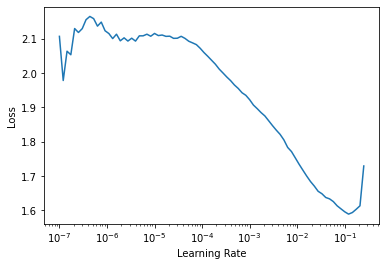

epoch,train_loss,valid_loss,MapMetric,time
0,0.913795,7.112163,0.091090,01:26
1,0.876072,1.282321,0.272120,01:14
2,0.856183,1.012936,0.413542,01:14
3,0.805569,0.871241,0.427381,01:14
4,0.769702,0.791837,0.522204,01:15
5,0.719438,0.784379,0.526555,01:15
6,0.661677,0.794286,0.530905,01:14


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  5.47it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


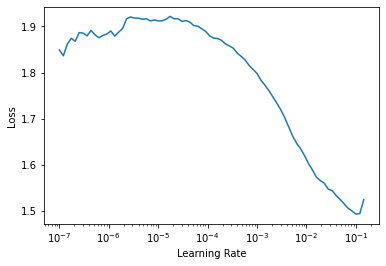

epoch,train_loss,valid_loss,MapMetric,time
0,0.906579,1.081053,0.296506,01:24
1,0.890837,2.481365,0.152636,01:24
2,0.847466,1.026336,0.311019,01:23
3,0.825567,0.824078,0.482898,01:24
4,0.773314,0.802184,0.509160,01:24
5,0.713765,0.784591,0.527630,01:23
6,0.677379,0.793229,0.537162,01:24


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  5.48it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


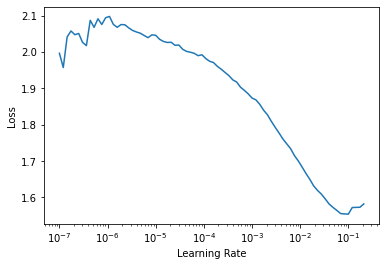

epoch,train_loss,valid_loss,MapMetric,time
0,0.902828,2.046308,0.168689,01:41
1,0.891226,1.467655,0.327980,01:39
2,0.866900,1.016516,0.353039,01:39
3,0.845065,0.861526,0.449530,01:40
4,0.787364,0.802518,0.519598,01:40
5,0.732567,0.787551,0.534975,01:41
6,0.684206,0.793333,0.528917,01:39


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  5.28it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


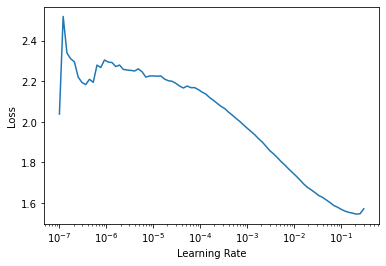

epoch,train_loss,valid_loss,MapMetric,time
0,0.894545,1.970173,0.275004,01:33
1,0.887679,1.094291,0.226473,01:36
2,0.853942,1.043174,0.391758,01:33
3,0.830116,0.853731,0.421194,01:34
4,0.788407,0.820981,0.480560,01:32
5,0.725746,0.779437,0.532502,01:33
6,0.682174,0.782526,0.531845,01:33


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  5.24it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


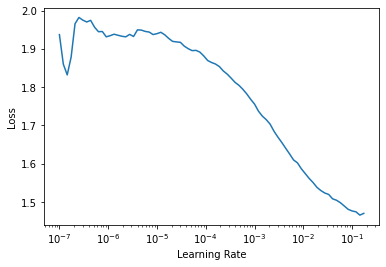

epoch,train_loss,valid_loss,MapMetric,time
0,0.887504,1.220992,0.312451,01:47
1,0.885895,1.168294,0.337865,01:46
2,0.851920,1.212590,0.317247,01:46
3,0.803024,0.860788,0.459272,01:46
4,0.778203,0.798685,0.523702,01:46
5,0.728484,0.780232,0.537579,01:46
6,0.671880,0.786278,0.534469,01:46


Calculating mAP: 100%|██████████| 11/11 [00:01<00:00,  5.56it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


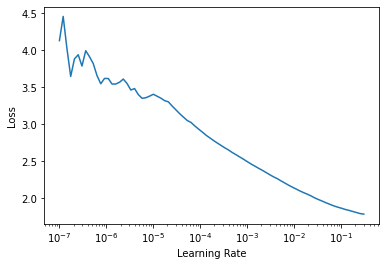

epoch,train_loss,valid_loss,MapMetric,time
0,0.911223,1.257001,0.375691,02:14
1,0.883962,2.569061,0.264721,02:18
2,0.858236,0.919656,0.388847,02:14
3,0.817804,0.884721,0.440864,02:17
4,0.799692,0.802048,0.506817,02:15
5,0.743596,0.783720,0.536720,02:17
6,0.682813,0.788207,0.535850,02:16


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  4.52it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


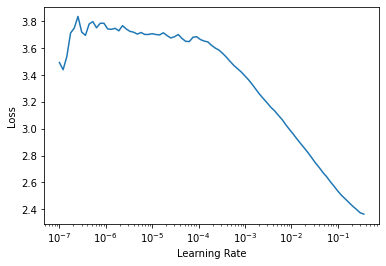

epoch,train_loss,valid_loss,MapMetric,time
0,1.151204,1.166748,0.136827,01:44
1,0.979651,1.215854,0.150973,01:42
2,0.930757,1.094566,0.194389,01:42
3,0.893607,0.961185,0.226058,01:42
4,0.823910,0.829766,0.471283,01:41
5,0.783639,0.811969,0.476101,01:44
6,0.762743,0.807580,0.484463,01:42


Calculating mAP:   0%|          | 0/11 [00:00<?, ?it/s]/workspace/train_detect.py:177: RuntimeWarning: overflow encountered in float_scalars
  union = b1.W * b1.H + b2.W * b2.H - intersection
/workspace/train_detect.py:169: RuntimeWarning: invalid value encountered in float_scalars
  x_e = min(b1.X + b1.W, b2.X + b2.W)
/workspace/train_detect.py:171: RuntimeWarning: invalid value encountered in float_scalars
  y_e = min(b1.Y + b1.H, b2.Y + b2.H)
Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  4.99it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


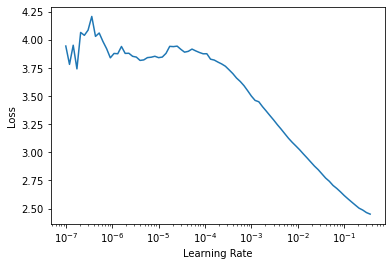

epoch,train_loss,valid_loss,MapMetric,time
0,1.162642,1.151204,0.146093,02:01
1,0.988119,1.030034,0.221543,01:58
2,0.925809,0.985224,0.197537,01:58
3,0.871871,0.890332,0.366409,01:57
4,0.847398,0.833285,0.457883,01:56
5,0.792481,0.808105,0.500113,01:57
6,0.737116,0.807583,0.501092,01:56


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  5.01it/s]


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 1433


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 1431


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 1430


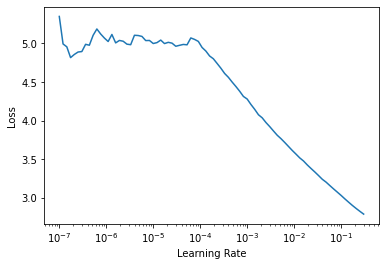

epoch,train_loss,valid_loss,MapMetric,time
0,1.172562,1.140833,0.148655,02:32
1,0.992142,1.052952,0.173934,02:28
2,0.945304,0.938242,0.336585,02:27
3,0.903706,0.899998,0.369273,02:27
4,0.856885,0.856176,0.406329,02:28
5,0.807889,0.826937,0.465252,02:27
6,0.760386,0.824490,0.475072,02:27


Calculating mAP: 100%|██████████| 11/11 [00:02<00:00,  5.30it/s]


In [22]:
run_tests(tests, lrs=[3.5e-3]*len(tests))

In [17]:
# DATA #

In [2]:
# Params
IMAGE_PATH = "jpg640_5fold"
NUM_FOLDS = 5
IMAGE_SIZE = 640
MODEL_NAME = "eff_ap4_640"
assert int(re.search(r'\d*$', MODEL_NAME)[0]) == IMAGE_SIZE, "Image size should match model"

BATCH_SIZE = 8

In [3]:
train_detect.make_base_models([MODEL_NAME])

Downloading: "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d4_ap-f601a5fc.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientdet_d4_ap-f601a5fc.pth


In [4]:
# [(train_ds, valid_ds), ...]
ds_folds = [
    train_detect.get_ds_train_valid(
        box_dir=IMAGE_PATH, 
        image_size=IMAGE_SIZE,
        fold_valid=fold,
    )
    for fold in range(NUM_FOLDS)
]
# train_detect.show_tfmd_imgs(train_ds)

INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 860


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 857


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 860


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 857


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 860


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 857


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 860


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 857


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 857


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 860


In [5]:
# Sanity check fold counts
for train_ds, valid_ds in ds_folds:
    print(len(train_ds), len(valid_ds))

3437 857
3435 859
3435 859
3435 859
3434 860


In [6]:
# [(train_dl, valid_dl), ...]
dl_folds = [
    train_detect.get_dl_train_valid(
        train_ds=train_ds, valid_ds=valid_ds, model_name=MODEL_NAME, 
        batch_size=BATCH_SIZE,
    )
    for train_ds, valid_ds in ds_folds
]

In [7]:
# LEARN #
learn_folds = [
    train_detect.get_learner(
        train_dl=train_dl, valid_dl=valid_dl, model_name=MODEL_NAME
    )
    for train_dl, valid_dl in dl_folds
]

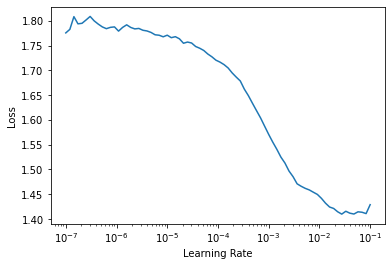

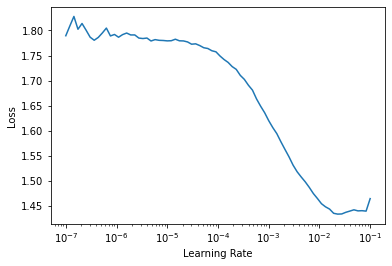

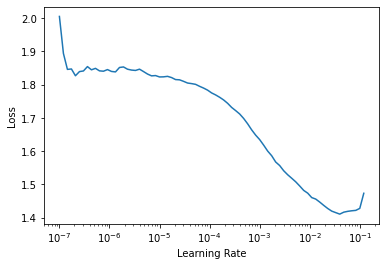

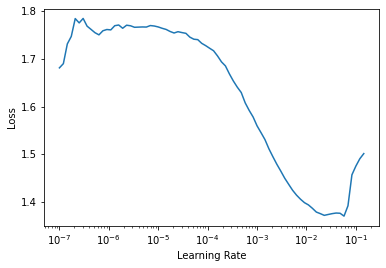

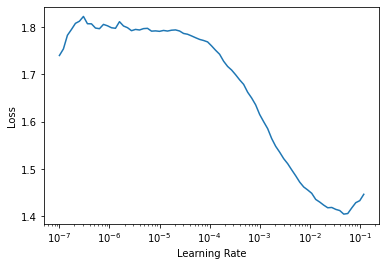

In [8]:
for learn_fold in learn_folds:
    learn_fold.lr_find()

In [9]:
for i, learn in enumerate(learn_folds):
    print(f"Training fold {i}")
    learn.fit_one_cycle(4, 1.5e-3)
    plt.pause(0.001)

Training fold 0


epoch,train_loss,valid_loss,MapMetric,time
0,0.894923,1.312667,0.254513,03:36
1,0.839532,0.856792,0.456689,03:30
2,0.773189,0.799126,0.525071,03:28
3,0.716741,0.762734,0.564167,03:28


Calculating mAP: 100%|██████████| 11/11 [00:01<00:00, 10.43it/s]


Training fold 1


epoch,train_loss,valid_loss,MapMetric,time
0,0.877134,1.232824,0.235782,03:31
1,0.847372,0.939713,0.458133,03:29
2,0.772631,0.788988,0.522764,03:28
3,0.720599,0.766675,0.551904,03:28


Calculating mAP: 100%|██████████| 11/11 [00:01<00:00,  9.90it/s]


Training fold 2


epoch,train_loss,valid_loss,MapMetric,time
0,0.896986,1.662093,0.217724,03:30
1,0.847514,0.870326,0.504380,03:28
2,0.772822,0.788918,0.553012,03:27
3,0.711528,0.761731,0.581589,03:28


Calculating mAP: 100%|██████████| 11/11 [00:01<00:00, 10.27it/s]


Training fold 3


epoch,train_loss,valid_loss,MapMetric,time
0,0.898015,1.440594,0.299035,03:29
1,0.836377,1.069268,0.272261,03:29
2,0.792189,0.786693,0.547985,03:28
3,0.723967,0.766678,0.570678,03:28


Calculating mAP: 100%|██████████| 11/11 [00:01<00:00, 10.02it/s]


Training fold 4


epoch,train_loss,valid_loss,MapMetric,time
0,0.880185,1.570260,0.150163,03:35
1,0.832116,0.985025,0.454003,03:28
2,0.787299,0.800999,0.537870,03:27
3,0.709940,0.783249,0.546645,03:27


Calculating mAP: 100%|██████████| 11/11 [00:01<00:00,  9.95it/s]


In [10]:
for learn_fold in learn_folds:
    learn_fold.model = learn_fold.model.eval()

In [11]:
train_detect.save_learn_folds(learn_folds=learn_folds, model_name=MODEL_NAME)

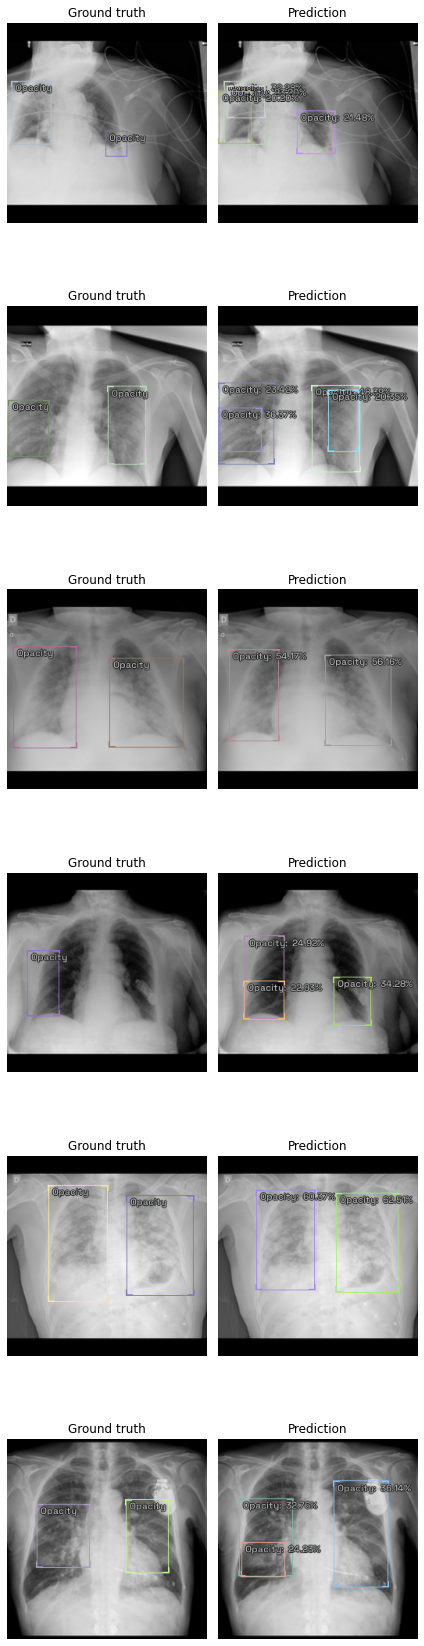

In [23]:
model_type = train_detect.model_name_to_type(MODEL_NAME)
model_type.show_results(learn.model, valid_ds, detection_threshold=0.2)

In [34]:
# Takes a long time. Only do this for heavy-duty error analysis
# model_type.interp.plot_top_losses(learn.model, valid_ds, n_samples=100)

In [27]:
for fold, learn in enumerate(learn_folds):
    preds = train_detect.predict_and_save(
        box_dir=IMAGE_PATH, 
        image_size=IMAGE_SIZE,
        model_name=MODEL_NAME, 
        model=learn.model, 
        fold=fold,
        is_test=False,
    )

INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold0): 857


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold1): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold2): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold3): 859


INFO     - Autofixing records | icevision.parsers.parser:parse:136



Num records (fold4): 860


In [31]:
list(preds[list(preds)[0]].values())[0] # Should be a ton of preds

array([0.40452835, 0.36730385, 0.26472747, 0.21209212, 0.19918911,
       0.1931855 , 0.18736567, 0.18663979, 0.14746068, 0.1157089 ,
       0.11486703, 0.10721184, 0.10596239, 0.10566339, 0.09022172,
       0.08616931, 0.08441127, 0.07812812, 0.07810041, 0.07736755,
       0.07658145, 0.07485466, 0.0687012 , 0.06742278, 0.06719746,
       0.06532364, 0.06265062, 0.05793627, 0.05597911, 0.05534032,
       0.05358922, 0.05318363, 0.0471665 , 0.04662152, 0.04591654,
       0.04499463, 0.04357199, 0.04281036, 0.04167274, 0.04085744,
       0.04067114, 0.04019918, 0.03954779, 0.03814261, 0.03782264,
       0.0374116 , 0.03733431, 0.03723534, 0.03710007, 0.03689102,
       0.03678869, 0.03500668, 0.03495962, 0.03383537, 0.03267324,
       0.03161189, 0.03045969, 0.03001213, 0.02851165, 0.02806264,
       0.02730284, 0.02723905, 0.0268832 , 0.0266618 , 0.02662071,
       0.02660754, 0.02658526, 0.02608669, 0.02569058, 0.02545314,
       0.02519801, 0.0251606 , 0.02501381, 0.02497454, 0.02448